In [1]:
from ngmix.medsreaders import NGMixMEDS, MultiBandNGMixMEDS
import proplot as pplt
import numpy as np
import galsim

In [42]:
m = NGMixMEDS("/Users/beckermr/Desktop/DES0433-2332_r_des-pizza-slices-y6-v15_meds-pizza-slices.fits.fz")
mm = MultiBandNGMixMEDS([m])

In [43]:
icut = 35

obs = m.get_obs(icut, 0)
mbobs = mm.get_mbobs(icut)

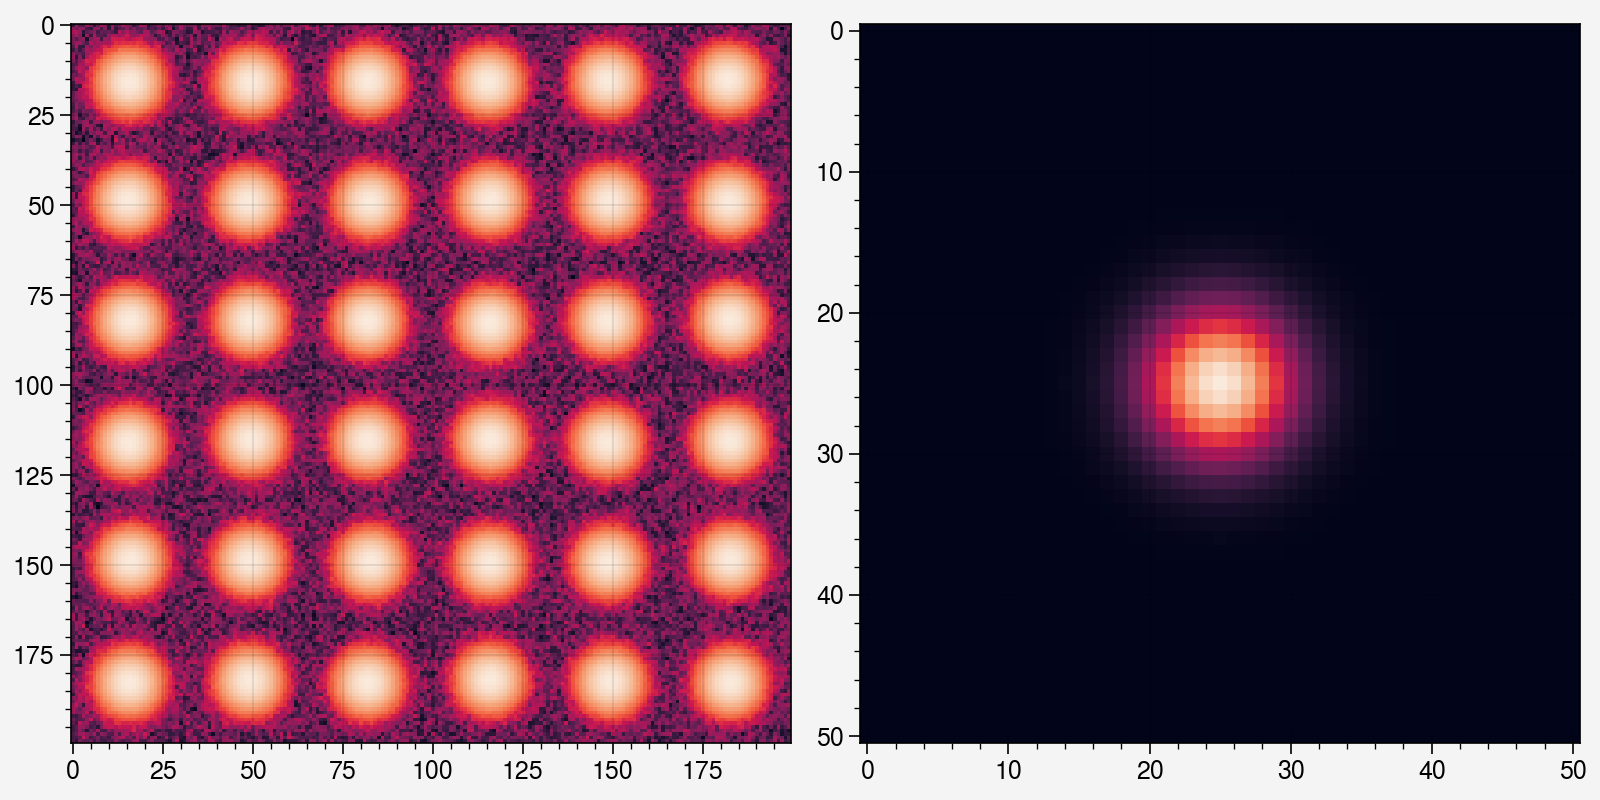

In [44]:
fig, axs = pplt.subplots(
    nrows=1, ncols=2, 
    share=0,
    figsize=(8, 4)
)

ax = axs[0]
ax.imshow(
    np.arcsinh(obs.image * np.sqrt(obs.weight)), 
    cmap='rocket',
)

ax = axs[1]
ax.imshow(
    obs.psf.image,
    cmap='rocket',
)

In [ ]:
d = m.get_cat()

In [ ]:
d.dtype.names

In [ ]:
obs.psf.jacobian

In [ ]:
obs.psf.image.sum()

In [ ]:
d["id"]

### run mdet

In [83]:
import yaml


config = yaml.safe_load("""
metacal:
  psf: fitgauss
  types: [noshear, 1p, 1m, 2p, 2m]
  use_noise_image: True

# use defaults in sxdes package
sx: null

fitters:
  - model: wmom
    weight:
      fwhm: 1.2
  - model: pgauss
    weight:
      fwhm: 2.0
  - model: pgauss
    weight:
      fwhm: 2.0
      fwhm_reg: 0.9

# any regions where the bmask is set with one of these flags will be masked
# out of detection
nodet_flags: 33554432  # 2**25 is GAIA stars

# check for hitting the edge when fitting
bmask_flags: 1610612736  # 2**29 | 2**30 edge in either MEDS of pizza cutter

mfrac_fwhm: 2  # arcsec

meds:
  box_padding: 2
  box_type: iso_radius
  max_box_size: 48
  min_box_size: 48
  rad_fac: 2
  rad_min: 4
""")

from metadetect import do_metadetect

In [ ]:
res = do_metadetect(config, mbobs, np.random.RandomState(seed=10))

In [ ]:
key = "noshear"

for i in range(len(res[key])):
    print("%d:" % i)
    for k in res[key].dtype.names:
        print("    %s: %r" % (k, res[key][k][i]))

### try a simple sim

In [2]:
import galsim

In [199]:
gal = galsim.Exponential(half_light_radius=0.5)
psf = galsim.Gaussian(sigma=1)
scale = 0.263
dim = 48
cen = (dim-1)/2
ivar = 1e8

shift = scale * dim/1.7

rng = np.random.default_rng(34543)

def _dither(g):
    dx = (rng.uniform()-1)/2 * scale
    dy = (rng.uniform()-1)/2 * scale
    return g.shift(dx=dx, dy=dy)
    

obj = (
    gal
    + _dither(gal).shift(dx=shift, dy=0)
    + _dither(gal).shift(dx=0, dy=shift)
    + _dither(gal).shift(dx=-shift, dy=0)
    + _dither(gal).shift(dx=0, dy=-shift)
    + _dither(gal).shift(dx=shift, dy=shift)
    + _dither(gal).shift(dx=-shift, dy=shift)
    + _dither(gal).shift(dx=-shift, dy=-shift)
    + _dither(gal).shift(dx=shift, dy=-shift)
)
obj = galsim.Convolve(obj, psf)

obj_single = galsim.Convolve(gal, psf)

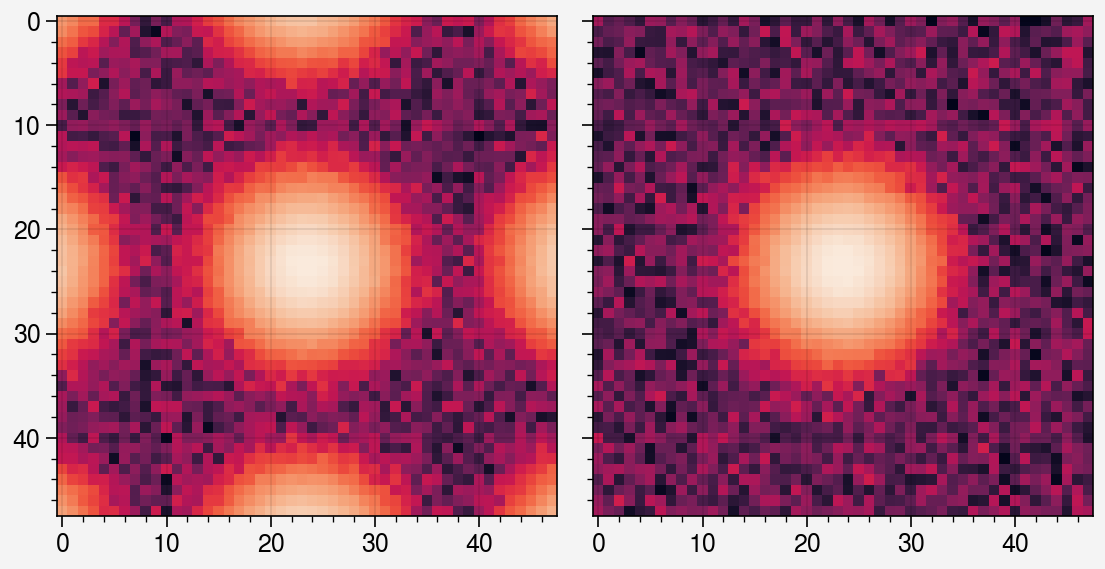

In [200]:
fig, axs = pplt.subplots(nrows=1, ncols=2)

rng = np.random.default_rng(34543)

im = obj.drawImage(nx=dim, ny=dim, scale=scale).array
im += rng.normal(size=im.shape, scale=1.0/np.sqrt(ivar))
axs[0].imshow(np.arcsinh(im * np.sqrt(ivar)), cmap="rocket")

im = obj_single.drawImage(nx=dim, ny=dim, scale=scale).array
im += rng.normal(size=im.shape, scale=1.0/np.sqrt(ivar))
axs[1].imshow(np.arcsinh(im * np.sqrt(ivar)), cmap="rocket")

In [204]:
import ngmix

def _meas(_obj, psf, ivar):
    rng = np.random.default_rng()
    im = _obj.drawImage(nx=dim, ny=dim, scale=scale)
    jac = ngmix.DiagonalJacobian(scale, row=dim/2, col=dim/2)
    psf = ngmix.Observation(
        image=psf.drawImage(nx=dim+1, ny=dim+1, scale=scale).array,
        jacobian=jac,
    )
    jac = ngmix.DiagonalJacobian(scale, row=cen, col=cen)
    obs = ngmix.Observation(
        image=im.array + rng.normal(size=im.array.shape, scale=1.0/np.sqrt(ivar)),
        weight=np.ones_like(im.array) * ivar,
        jacobian=jac,
        psf=psf,
    )
    res = ngmix.prepsfmom.PGaussMom(2).go(obs)
    return res

In [205]:
_meas(obj, psf, ivar)["s2n"]

27.992632952420916

In [206]:
_meas(obj_single, psf, ivar)["s2n"]

28.608274789813496

### look at what sx finds

In [154]:
from metadetect.detect import MEDSifier

In [190]:
icut = 35

obs = m.get_obs(icut, 0)
mbobs = mm.get_mbobs(icut)

mfier = MEDSifier(mbobs, config.get("sx", {}), config["meds"])

mbmeds = mfier.get_multiband_meds()

56.10676537447236

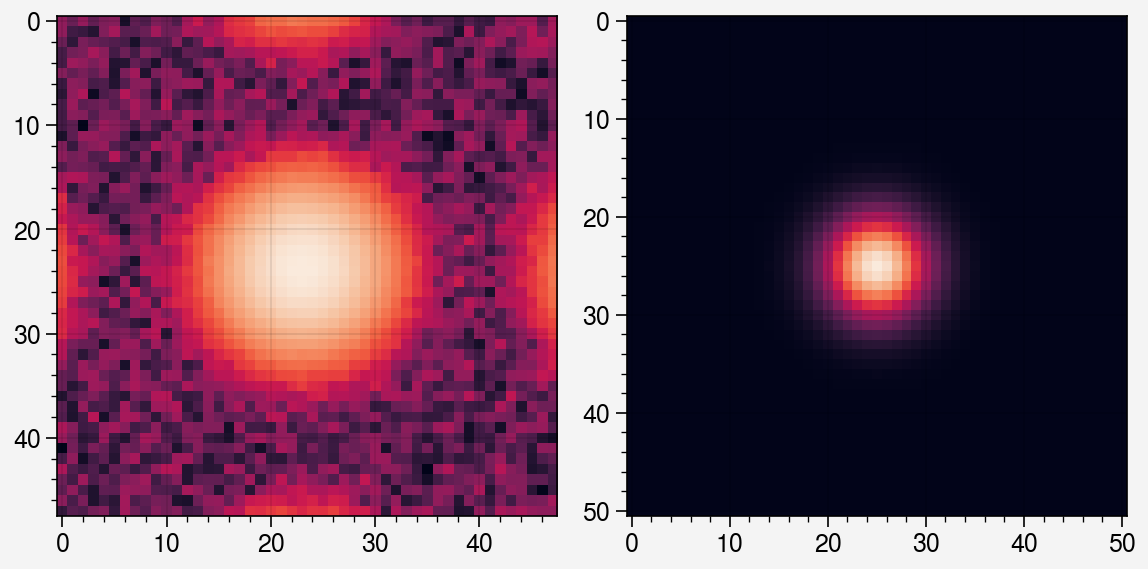

In [191]:
icut = 45

mbobs = mbmeds.get_mbobs(10)
obs = mbobs[0][0]

fig, axs = pplt.subplots(
    nrows=1, ncols=2, 
    share=0,
)

ax = axs[0]
ax.imshow(
    np.arcsinh(obs.image * np.sqrt(obs.weight)), 
    cmap='rocket',
)

ax = axs[1]
ax.imshow(
    obs.psf.image,
    cmap='rocket',
)

ngmix.prepsfmom.PGaussMom(2).go(obs)["s2n"]

In [198]:
from ngmix.moments import T_to_fwhm, sigma_to_fwhm
T_to_fwhm(ft.go(obs.psf, 1)["T"]), sigma_to_fwhm(0.9)

(2.361156507441539, 2.1193380405278543)

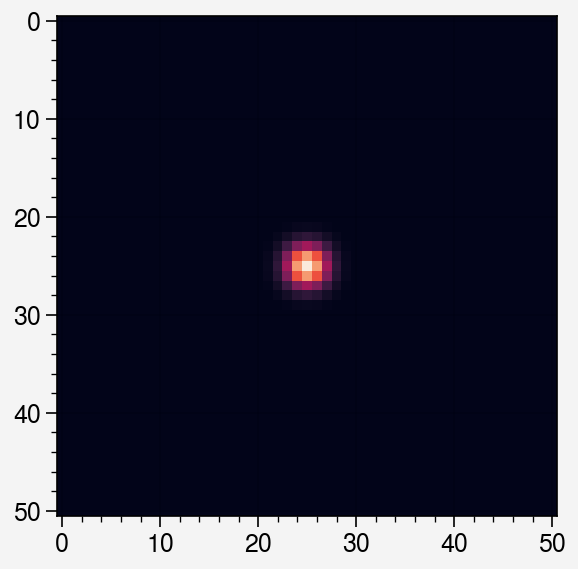

In [184]:
psf = galsim.Gaussian(fwhm=0.9)
scale = 0.263
im = psf.drawImage(nx=51, ny=51, scale=0.263).array

fig, axs = pplt.subplots()
axs.imshow(
    im,
    cmap='rocket',
)

In [187]:
ft = ngmix.admom.AdmomFitter()

AttributeError: 'Observation' object has no attribute 'paf'